# setup

In [1]:
import socket
import os

hostname = socket.gethostname()
if hostname == 'simurgh':
    os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"
    
import time
import importlib
import keras
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TerminateOnNaN
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import arviz as az
import netCDF4 as nc
import load_ppe_fun as lp
import tuning_fun as tu
import emulator_fun as ef
import MCMC_fun as mf
import util_fun as uf

2025-10-09 15:10:27.392893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760022627.572567 2128712 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760022627.609961 2128712 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760022628.006701 2128712 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760022628.006728 2128712 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760022628.006731 2128712 computation_placer.cc:177] computation placer alr

In [2]:
# set up and check if GPU is being used


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [8]:
importlib.reload(ef)

<module 'emulator_fun' from '/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py'>

In [9]:
run_name = 'fullmp_ppe_r1_momsf_momval_pratespec_sedflux4layers_knowntruths'
filename = run_name + '_N2000.nc'
var_select = None
# var_select = ['M0_path_last4hrmean',
#               'M3_path_last4hrmean',
#               'M4_path_last4hrmean',
#               'M6_path_last4hrmean',
#               'sfM0_10m_last4hrmean',
#               'sfM3_10m_last4hrmean',
#               'sfM4_10m_last4hrmean',
#               'sfM6_10m_last4hrmean']
params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler_asinh'
x_train, x_val, y_train, y_val, tgt_data, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=True, set_nan_to_neg1001=True, var_select=var_select)

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']

Transforming data...: 100%|██████████| 24/24 [00:00<00:00, 2028.81it/s]


In [ ]:
# fig = plt.figure(figsize=(15, 5))
# gs = gridspec.GridSpec(1,nvar)
# for i, eff0 in enumerate(eff0s):
#     ax = fig.add_subplot(gs[i])
#     _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
#                  bins=100,
#                  density=True,
#                  label=['BOSS PPE', 'target'])
#     plt.legend()
#     # plt.yscale('log')
#     plt.title(var_constraints[i])

Next, try out different ML architectures...

## CRPS

In [53]:
proj_name = f'crps_{run_name}_{transform_method}'
if var_select is not None: 
    proj_name += "".join([varstr[0] for varstr in var_select])
    print('proj_name:', proj_name)

varcons = ppe_info['var_constraints']
y_train_nopres = {k: v for k, v in y_train.items() if 'presence_' not in k}
y_val_nopres = {k: v for k, v in y_val.items() if 'presence_' not in k}

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_reg_crps_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/crps',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train_nopres,
    epochs=25,
    validation_data=(x_val, y_val_nopres),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

Reloading Tuner from hp_tuning/crps/crps_fullmp_ppe_r1_momsf_momval_pratespec_sedflux4layers_knowntruths_standard_scaler_asinh/tuner0.json


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 192)       │      4,800 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 160)       │     30,880 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 224)       │     36,064 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 160)       │     36,000 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0_path_last4hrmean │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3_path_last4hrmean │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4_path_last4hrmean │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6_path_last4hrmean │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last4hrme… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last4hrstd │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ precip_max_dm       │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ precip_onset        │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_10m_last4hrme… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_250m_last4hrm… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_500m_last4hrm… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_750m_last4hrm… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM3_10m_last4hrme… │ (None, 2)         │        322 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                 

 Total params: 115,472 (451.06 KB)

 Trainable params: 115,472 (451.06 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train_nopres,
    epochs=1000,
    verbose=0,
    validation_data=(x_val, y_val_nopres),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2025-10-09 17:29:11.882924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2236', 16 bytes spill stores, 16 bytes spill loads

2025-10-09 17:29:11.927097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2229', 120 bytes spill stores, 120 bytes spill loads

2025-10-09 17:29:11.934657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2229', 12 bytes spill stores, 12 bytes spill loads

2025-10-09 17:29:11.939710: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2229', 164 bytes spill stores, 164 bytes spill loads

2025-10-09 17:29:11.948573: I extern

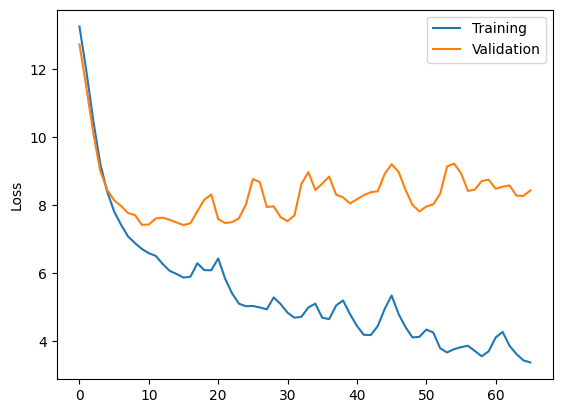

In [55]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## multi-output (explicit) model

In [11]:
# %%skip
proj_name = 'multioutput_unc_' + run_name + '_' + transform_method
if var_select is not None: 
    proj_name += "".join([varstr[0] for varstr in var_select])
    print('proj_name:', proj_name)
    
varcons = ppe_info['var_constraints']
nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_unc_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

Trial 25 Complete [00h 01m 23s]
val_loss: 41.8088264465332

Best val_loss So Far: 19.105459213256836
Total elapsed time: 00h 32m 16s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 160)       │      4,000 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     20,608 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 96)        │     12,384 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0_path_last4hrmean │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3_path_last4hrmean │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4_path_last4hrmean │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6_path_last4hrmean │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last4hrme… │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last4hrstd │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ precip_max_dm       │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ precip_onset        │ (None, 2)         │        194 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M0_path_l… │ (None, 1)         │         97 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M3_path_l… │ (None, 1)         │         97 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M4_path_l… │ (None, 1)         │         97 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M6_path_l… │ (None, 1)         │         97 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_prate_dm_… │ (None, 1)         │         97 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_prate_dm_… │ (None, 1)         │         97 │ dense_7[0][0]   

 Total params: 43,976 (171.78 KB)

 Trainable params: 43,976 (171.78 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

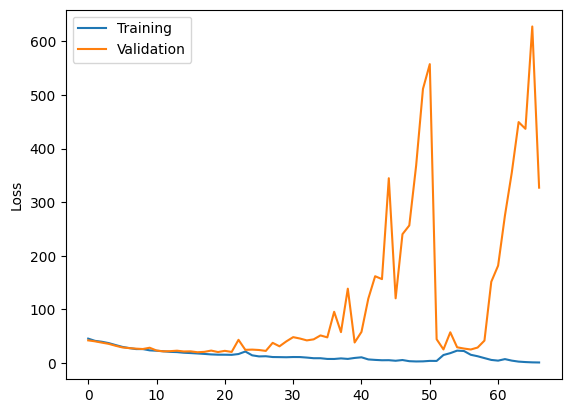

In [16]:
# %%skip
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## validation

In [56]:
# proj_name = 'crps_fullmp_ppe_r0_cov_last2hrmean_prate_sedflux_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

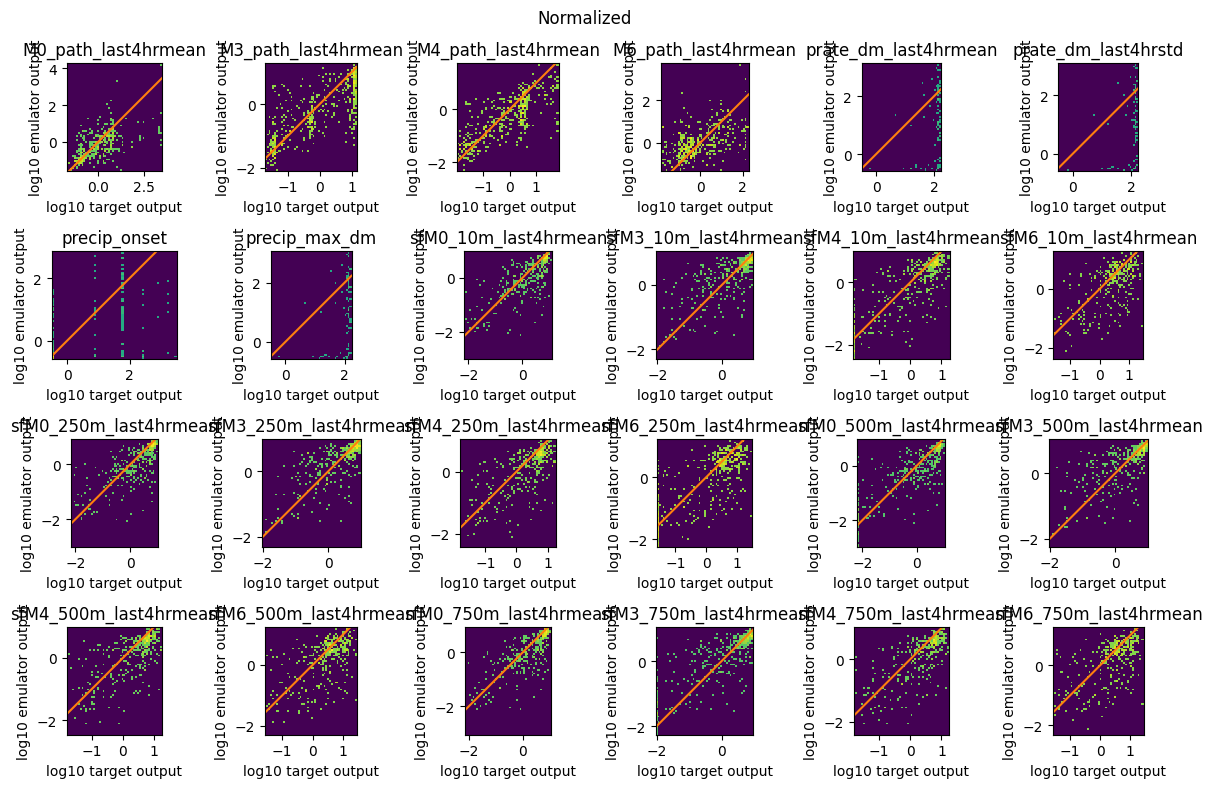

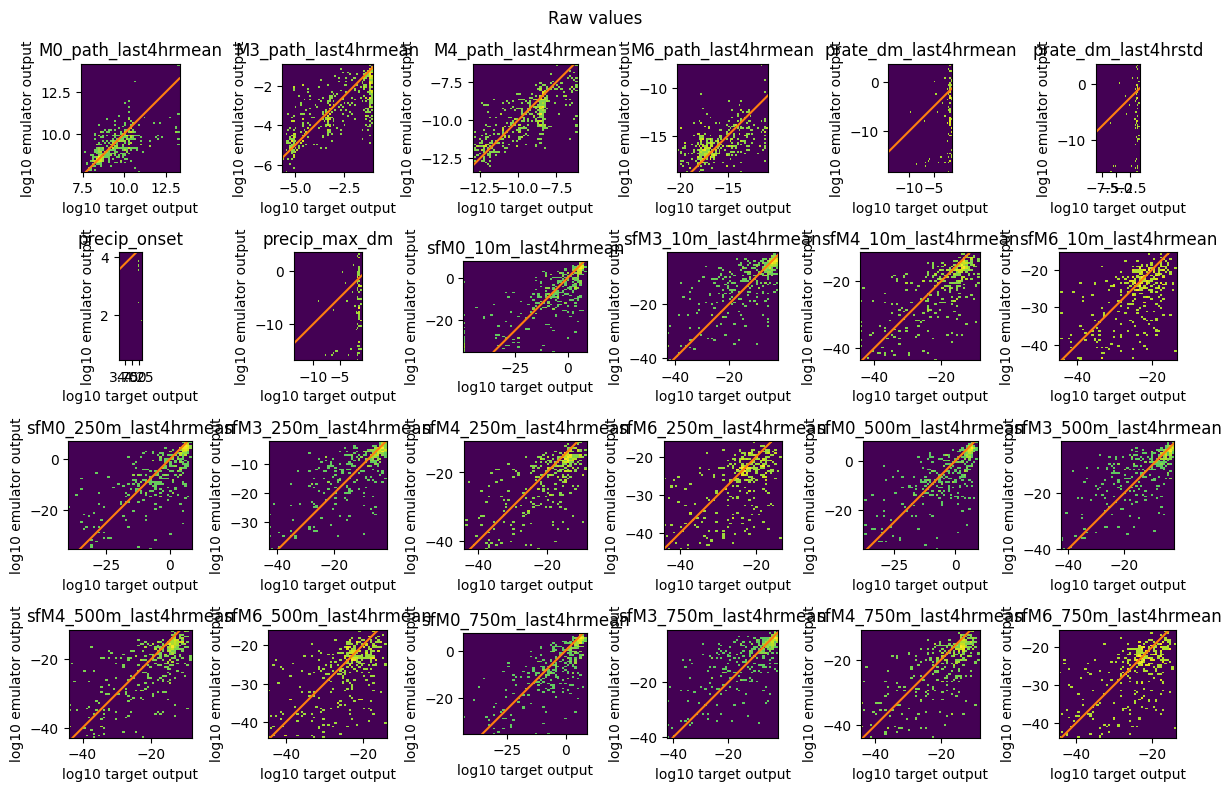

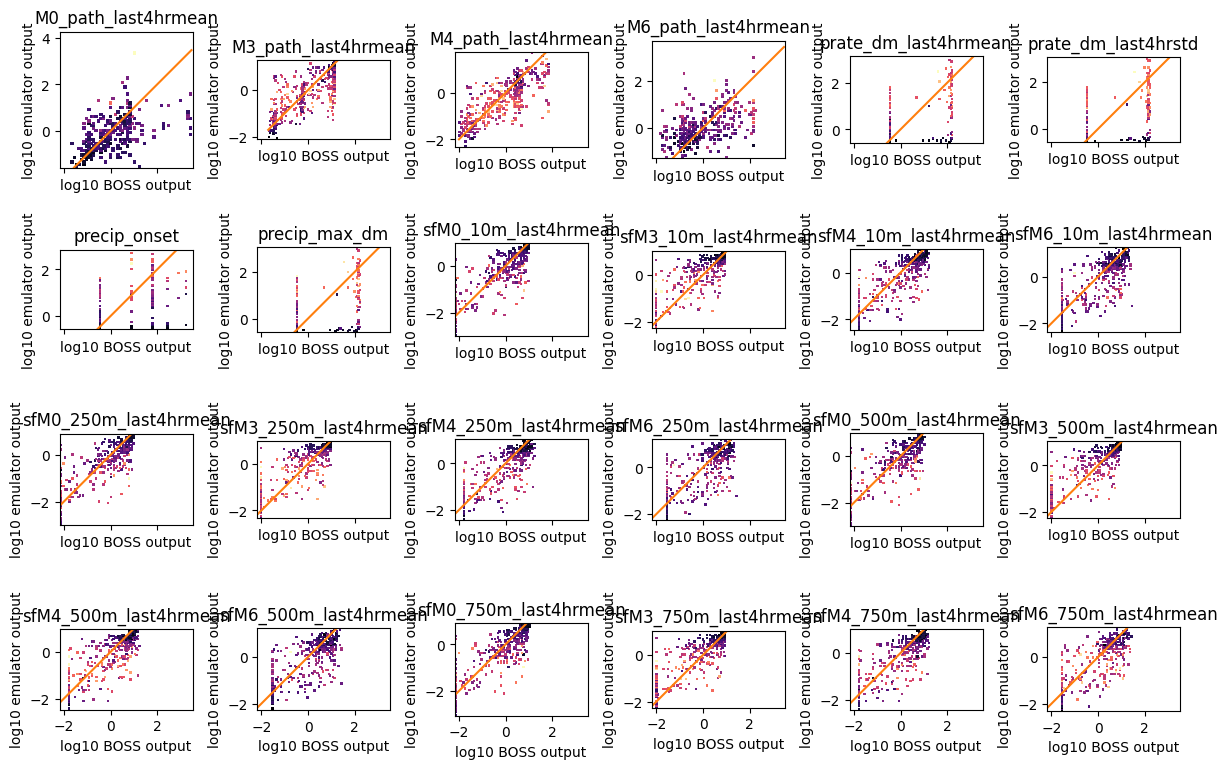

In [57]:
importlib.reload(ef)
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=True)

In [58]:
# List top memory variables
# top_vars = uf.get_top_memory_vars(globals())
uf.detailed_memory_analysis()
# # Free likely iterated/temporary variables
# free_iterated_vars(locals())

# # Optionally, show top memory variables again after cleanup
# print("\nAfter cleanup:")
# get_top_memory_vars(locals())

=== Memory Analysis ===
RSS (Resident Set Size): 23.93 GB
VMS (Virtual Memory Size): 89.34 GB
Shared Memory: 0.46 GB
Text Segment: 0.00 GB
Data Segment: 28.69 GB


# MCMC

## setup

In [59]:
# proj_name = 'crps_fullmp_ppe_r1_momsf_momval_pratespec_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [60]:
# MCMC
nchains = 8
num_burnin_steps = 5000
num_samples = 10000

# log prob function related
tau = 0.05
inflate_factor = .2

In [61]:
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = f'{lp.param_dir}param_fullmp_ppe_r0_cov_momval_prate_sedflux_r1.csv'
target_param_csv = f'{lp.param_dir}param_fullmp_ppe_r1_momsf_momval_prate_sedflux_r1.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()
all_param_names = param_table.columns[1:].to_list()

target_param_table = pd.read_csv(target_param_csv)

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[2, 1+param_interest_idx].astype(np.float32)
target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

print_table = pd.DataFrame({'param names': param_names, 'prior mean': param_mean, 'prior std': param_std, 'target mean': target_param_mean})
print(print_table)

   param names  prior mean  prior std  target mean
0    a0coal_db  -85.574074   5.990890   -92.607109
1       bmcoal    0.944560   0.472361     1.121269
2      bn0coal    2.090771   0.444890     3.592236
3      bnxcoal    1.912623   0.441040     0.817343
4      bnycoal    2.036242   0.507258     2.426582
5      bx0coal    1.543539   0.518888     0.195789
6      bxxcoal    1.529428   0.743166     2.375901
7      bxycoal    1.345752   0.951806    -0.758424
8      by0coal    1.051687   0.737558    -0.825528
9      byxcoal    1.655127   1.060902     1.985298
10     byycoal    1.981496   1.004724     0.608773
11  mtrans0_db   -5.059362  13.367868     8.949745
12    afall_db   22.590105  26.799278   -77.559166
13      bnfall   -0.352402   3.332587    -0.694693
14     bx0fall   -0.051183   0.751480     3.356076
15     bx3fall    1.502088   0.973594     3.927193
16     bxxfall    1.445662   0.989637     1.793713
17     bxyfall    0.802669   1.392534     0.871668
18     by0fall   -0.237868   1.

In [62]:
tgt_data_tf32 = tf.concat([tf.cast(x, tf.float32) for x in tgt_data],axis=-1)

tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :], [nchains, 1, 1])
varcons = ppe_info['var_constraints']

## set up log prob function

In [63]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfs = tfp.experimental.stats

def get_BOSSemu_lp(params_sigma, l_diag=False, use_loglik=True):
    emu_mu_list, emu_sigma_list, emu_pres_list = [], [], []
    sigma_list, obs_lp_list, y_true_safe_list, mu_safe_list = [], [], [], []
    
    # priors on parameters

    params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta=tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0,0,:].numpy())

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i, varcon in enumerate(varcons):
            # set default presence value to 1 (true) if it's not a predicted by emulator (not by CRPS, yes by multioutput)
            pres = tf.ones([nchains, n_tgt_ics, nobs[i]], tf.float32)
            if f'presence_{varcon}' in y_emu.keys():
                pres   = tf.reshape(tf.cast(y_emu[f'presence_{varcon}'], tf.float32),
                                    [nchains, n_tgt_ics, nobs[i]])
            full   = tf.reshape(tf.cast(y_emu[varcon], tf.float32),
                                [nchains, n_tgt_ics, 2*nobs[i]])
            mu     = full[..., :nobs[i]]
            rawsig = full[..., nobs[i]:]  # raw scale; softplus later
            emu_pres_list.append(pres)
            emu_mu_list.append(mu)
            emu_sigma_list.append(tf.nn.softplus(rawsig) + 1e-6)
            
        emu_pres_chain  = tf.concat([p for p in emu_pres_list],  axis=-1)   # [chain, ic, var] 
        emu_mu_chain    = tf.concat([p for p in emu_mu_list],    axis=-1)
        emu_sigma_chain = tf.concat([p for p in emu_sigma_list], axis=-1)
        # print(emu_pres_rect.shape, emu_mu_rect.shape, emu_sigma_rect.shape, tf.stack(emu_pres_list[:5]).shape)
    else:
        raise ValueError('`y_emu` is not a dictionary. Not yet implemented.')

    for ichain in range(nchains):
        presence_pred = emu_pres_chain[ichain, ...]   # [nvar, n_ic, nobs]
        mu_pred       = emu_mu_chain[ichain, ...]
        sig_pred      = emu_sigma_chain[ichain, ...]
        y_true        = tgt_data_tf32                          # [nvar, n_ic, nobs]

        finite_mask = tf.math.is_finite(y_true)
        finite_w    = tf.stop_gradient(tf.cast(finite_mask, tf.float32))

        # soft presence gate (same as you had)
        thresh = tf.constant(0.1, tf.float32)
        tau    = tf.constant(0.05, tf.float32)
        w_soft = tf.sigmoid((presence_pred - thresh) / tau)

        w = finite_w * w_soft

        # safe tensors
        y_true_safe = tf.where(finite_mask, y_true, 0.0)
        mu_safe     = tf.where(finite_mask, mu_pred, 0.0)
        sig_safe    = tf.where(finite_mask, sig_pred, 0.0)
        
        #  Weighted scale (avoid NaN when few points are active)
        eps    = tf.constant(1e-6, tf.float32)
        w_sum  = tf.reduce_sum(w) + eps
        resid  = mu_safe - y_true_safe
        # mean_w = tf.reduce_sum(w * resid) / w_sum
        # var_w  = tf.reduce_sum(w * tf.square(resid - mean_w)) / w_sum
        # var_w  = tf.reduce_sum(w * tf.square(resid)) / w_sum
        sigma_eff = tf.sqrt(tf.square(resid) + tf.square(sig_safe))
        # sigma_eff = sig_safe
        # print(tf.square(resid), tf.square(sig_safe))
        # sigma_eff = sig_safe
        
        if l_diag:
            sigma_list.append(sigma_eff)
            y_true_safe_list.append(y_true_safe)
            mu_safe_list.append(mu_safe)

        if use_loglik:
            # Weighted log-likelihood
            logpdf = tfd.Normal(loc=y_true_safe, scale=sigma_eff).log_prob(mu_safe)
            obs_lp_list.append(tf.reduce_sum(w * logpdf))
        else:
            # CRPS per point (univariate, closed form)
            crps = mf.gaussian_crps_per_point(y_true_safe, mu_safe, sig_safe)  # [nvar, n_ic, nobs]
            score_chain = tf.reduce_sum(w * crps)   # average CRPS over active points
            obs_lp_list.append(-score_chain)
            
    obs_lp = tf.stack(obs_lp_list)                   # shape [nchains]
        
    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', inflate_factor * obs_lp.numpy().mean())
        # return param_lp, obs_lp * inflate_factor, crps, w, y_true_safe, mu_pred
        return obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list, resid, sig_safe
    else:
        return param_lp + obs_lp * inflate_factor

In [64]:
tf.random.set_seed(1)
# initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
initial_state = tf.random.normal([nchains, npar], seed=1)
# param_lp, obs_lp, crps, w, y_true_safe, mu_safe = get_BOSSemu_lp(initial_state, l_diag=True)
obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list, resid, sig_safe = get_BOSSemu_lp(initial_state, l_diag=True, use_loglik=False)
# target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
# target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
# target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
# target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
# target_chain = tf.cast(tf.tile(target_pwIC_norm[0,n_init:][None, :], [nchains, 1]), tf.float32)
# a = get_BOSSemu_lp(target_chain, l_diag=True)
# initial_state = tf.zeros([nchains, npar])
# param_lp, obs_lp, logpdf, noise_scale_list, weight_list = get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], 0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], -0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)

scaled parameters: [0.56999576 0.9158944  0.9072411  0.42344135 0.38993597 0.30849898
 0.54000455 0.41654184 0.6142907  0.22287238 0.7187622  0.2168608
 0.41780537 0.49786445 0.3793236  0.71317387 0.62491065 0.3326795
 0.8256969  0.5704297  0.54067326 0.49875095 0.32435048]
param_lp: -257.75586 obs_lp: -41.764626


In [65]:
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

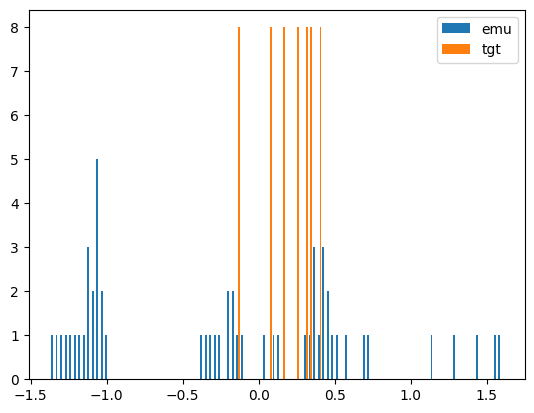

In [66]:
ivar = 0
# filtered = w.numpy().flatten()>0.5
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

emu_vs_tgt = [mu_safe_arr[:,:,ivar].flatten(), y_true_safe_arr[:,:,ivar].flatten()]
_ = plt.hist(emu_vs_tgt, bins=100)
plt.legend(['emu', 'tgt'])

# this is a histogram comparing range of target vs emulated constraint variables (in normalized scale). 
# having roughly the same range is indeed a good news, but otherwise it doesn't gaurantee a failure either. 
# could suggest either that the prior guess is way off or some structural issues. 

In [67]:
# Static diagonal preconditioner - pilot run to estimate sigma

initial_state = tf.random.normal([nchains, npar], seed=1)
pilot_hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=0.0005, num_leapfrog_steps=5)
@tf.function
def run_pilot_chain():
    return tfp.mcmc.sample_chain(num_results=100, num_burnin_steps=0,
                                   current_state=initial_state, kernel=pilot_hmc, 
                                   trace_fn=(lambda current_state, kernel_results: kernel_results), 
                                   seed=1)
z_pilot, kr_pilot = run_pilot_chain()

var = tf.math.reduce_variance(z_pilot, axis=[0,1]) + 1e-6
sigma = tf.sqrt(var)  # shape [npar]
print(sigma)

tf.Tensor(
[1.0305558  0.9230603  0.9801674  0.4228687  0.83470243 0.5721287
 0.77178633 1.0555705  1.3950232  1.1466631  1.180759   0.94671917
 1.2227081  1.1443111  0.91377264 1.2867521  1.1933243  1.0431705
 0.8782462  0.87875754 0.9667623  0.551092   0.93855214], shape=(23,), dtype=float32)


## actual run

In [68]:
stepsize = 0.1
bij = tfb.Blockwise([tfb.Sigmoid()] * npar)
rv0 = tfs.RunningVariance.from_stats(
    num_samples=tf.constant(0., initial_state.dtype),   # “empty” running variance
    mean=tf.zeros([npar], initial_state.dtype),
    variance=tf.ones([npar], initial_state.dtype),         # start with I
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
DA = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.5),
        target_accept_prob=0.75,
        )

precond = tfp.bijectors.Scale(sigma)

TTK = tfp.mcmc.TransformedTransitionKernel(
    bijector=precond,
    inner_kernel=DA,
)

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=TTK,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

samples, kr = run_chain()

end = time.time()
print(end-start)

194.13701677322388


acceptance rate: [0.7072 0.7765 0.7954 0.6961 0.7873 0.7024 0.7085 0.7906]


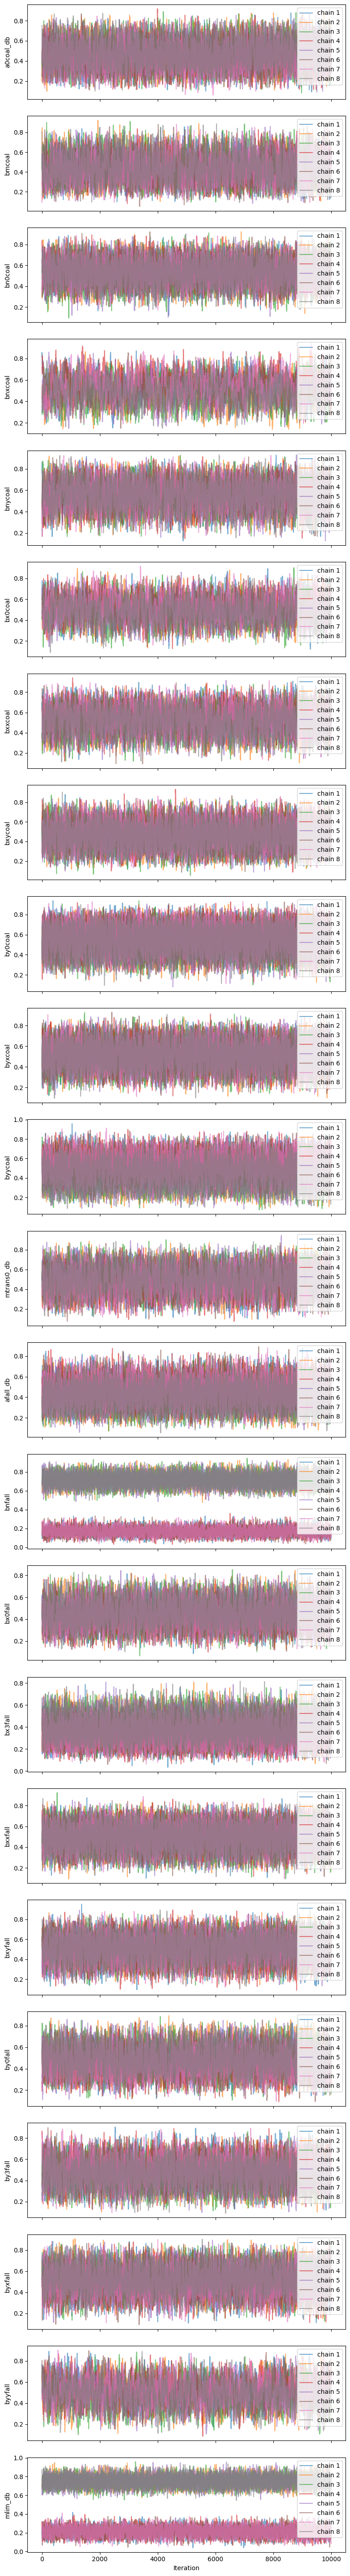

[[ 552.6674   294.92593  786.3813   173.41222  485.75986  283.76617
   479.2412   824.9931  1222.3986  1187.533   1039.0316   272.35904
   896.85815 1182.5337   798.51697  968.2479  1081.1562   714.8431
   638.2088   526.9226   591.86145  262.27542 1173.4026 ]
 [ 886.72046  514.26324  616.458    133.18515  641.0674   314.43475
   587.54486 1102.5828  1500.4642  1171.3691  1530.579    432.70288
  1186.8427  1352.9897   649.8119  1800.5625  1219.0583   949.4862
   567.65027  757.41864  884.2145   209.91904  992.72095]
 [ 700.24976  589.5467   701.5316   146.52182  665.02234  248.15085
   445.44397 1076.9402  1996.0996  1063.148   1350.9337   594.8078
  1437.4781  1878.2327   890.92786 1615.715   1037.2979  1158.2921
   678.2376   910.8841   939.5603   308.0216  1394.4419 ]
 [ 710.4256   493.89572  822.05035  194.87964  614.25244  340.42523
   543.5575   814.8841  1231.217    980.71124 1075.871    403.75742
   992.1283  1256.8799   599.18335 1073.7521   839.0031   653.7537
   665.09705  6

In [69]:
print("acceptance rate:", sum(kr.inner_results.inner_results.is_accepted.numpy())/num_samples)
# param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tfb.Sigmoid().forward(samples)
# transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
mf.plot_traces(transformed_samples, param_names)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [70]:
print("acc rate:", kr.inner_results.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.inner_results.new_step_size.numpy().min(), kr.inner_results.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.inner_results.log_accept_ratio))

acc rate: 0.7455
step_size range: 0.12602164 0.12602164
avg log_accept_ratio: -0.5313289


In [71]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 75.3757


In [72]:
with tf.GradientTape() as t:
    t.watch(initial_state)                # unconstrained params you sample in
    lprob = get_BOSSemu_lp(initial_state)
g = t.gradient(lprob, initial_state)         # shape [..., D]
gn = tf.math.reduce_std(g, axis=0)  # per-dim
print(gn)

tf.Tensor(
[ 3.4032488  4.0370684  3.08142    2.408649   2.4762688  4.3869767
  1.6869732  3.3889537  4.1995993  3.9785028  4.0095344  5.7791595
  3.5008297 10.160306   3.1472125  4.8336296  4.8347473  4.936383
  2.9746323  4.672558   4.6424975  1.8840983 15.0910635], shape=(23,), dtype=float32)


## postprocessing

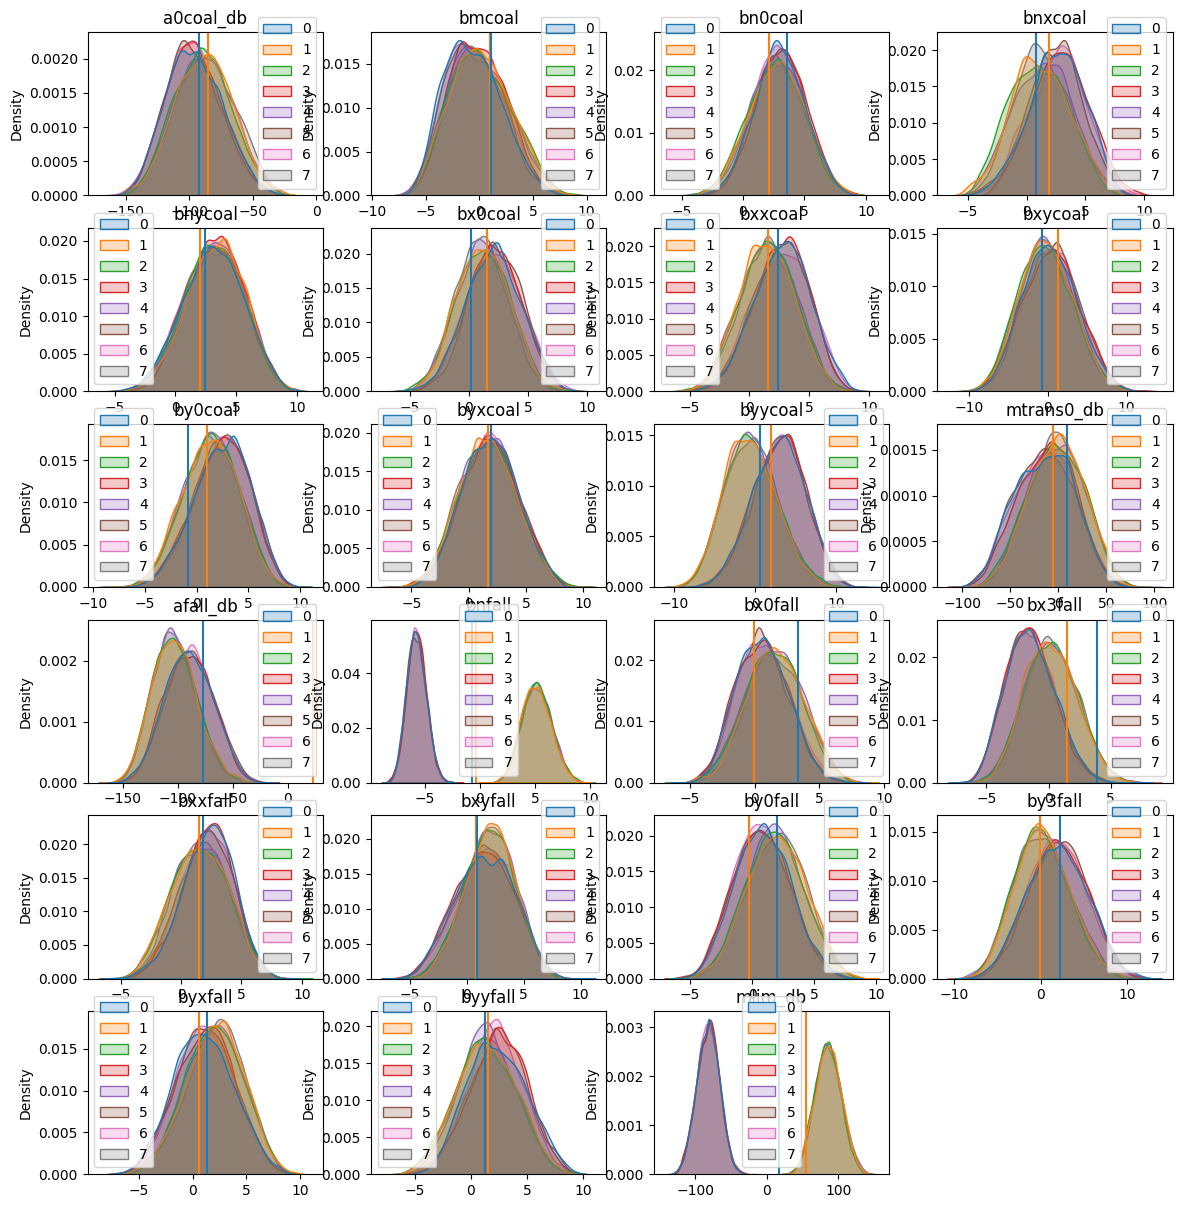

In [73]:
import seaborn as sns

IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
# IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = scalers['x'].inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)

$$
\frac{dM_i}{dt} \propto a_{0,coal}M^2_0\frac{\tilde{m}^{b_{n,i}}}{\tilde{m}^{b_{m}} + m_{trans}^{b_m}}K^{b_{x,i}}_{0,3,x}K^{b_{y,i}}_{3,x,y}
$$

x=4, y=6 for ith order moment

## validation

/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py:377: RuntimeWarning: invalid value encountered in divide
  hist = hist/hist.sum()


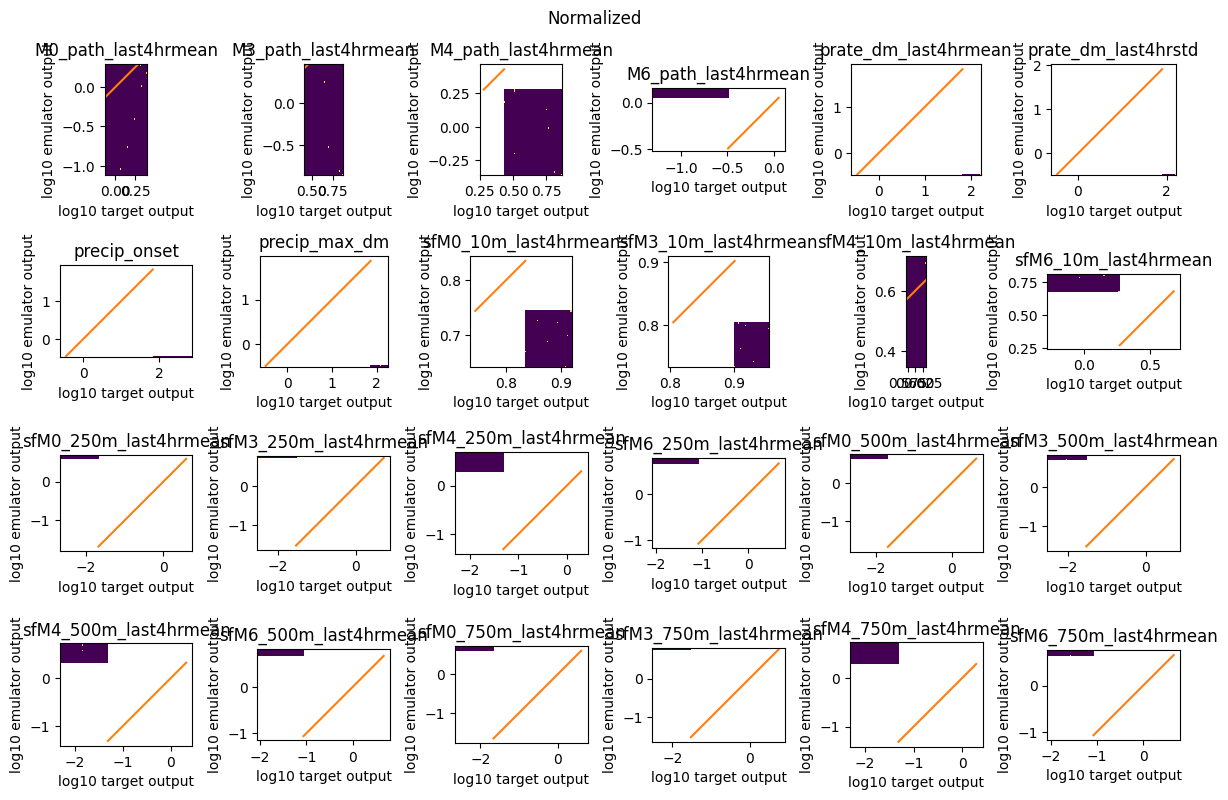

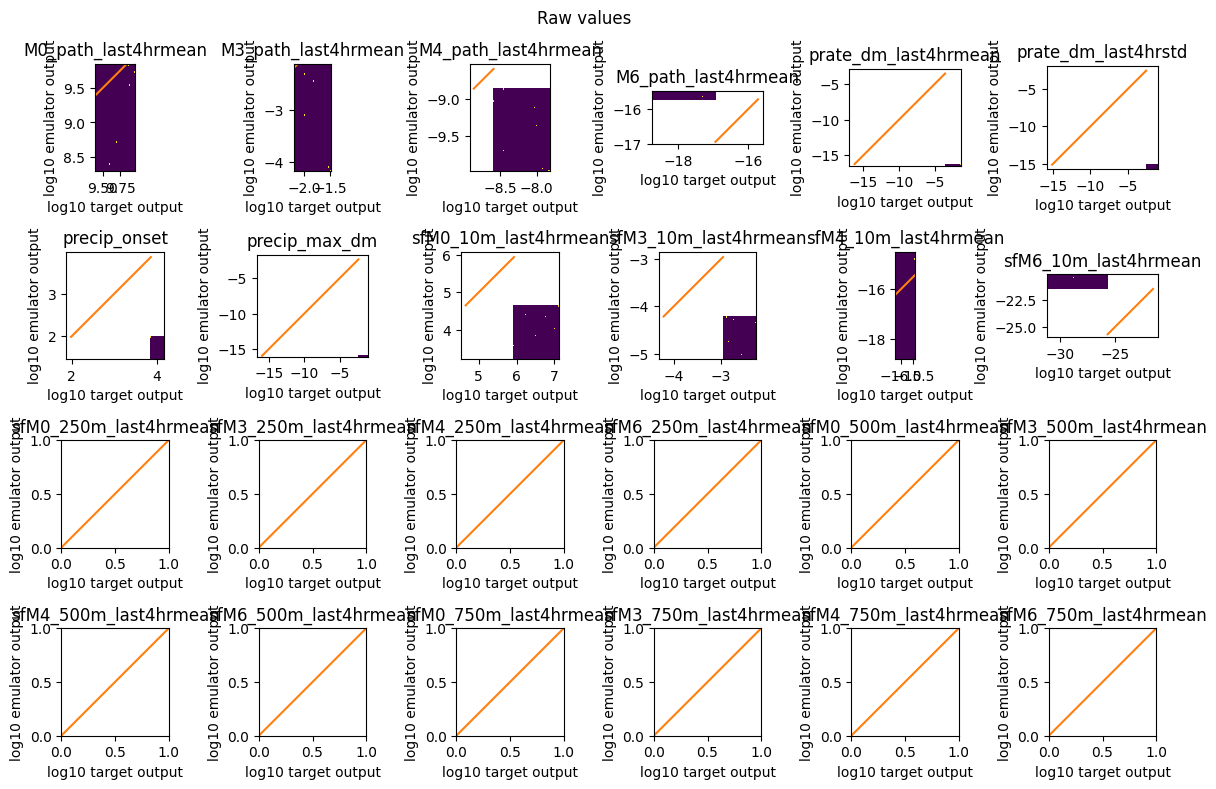

In [74]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)

ef.plot_emulator_results(meanresults_incl_ics, tgt_data, best_model, ppe_info, transform_method, scalers)

# Save MCMC results

## update params csv

In [75]:
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)

In [76]:
original_params = pd.read_csv(orig_param_csv)
updated_params = original_params.copy()
sample_mean = np.mean(sample_sum_chains, axis=0)
sample_std = np.std(sample_sum_chains, axis=0)

for iparam, param_name in enumerate(param_names):
    updated_params.loc[0, param_name] = sample_mean[iparam]
    updated_params.loc[2, param_name] = sample_std[iparam]

updated_params.to_csv(f'{lp.param_dir}/param_{run_name}_crps.csv', index=False)

In [77]:
pd.set_option('display.max_columns',None)
updated_params

Unnamed: 0  a0evap1_db  a0evap2_db  bm0evap1  bm0evap2  bx0evap1  bx0evap2  \
0       mean  -23.530267  -53.491215  0.006542  0.322378  2.012595  4.758512   
1         sd    2.255964    3.114923  0.003238  0.132059  0.168649  0.137407   
2        isd    2.207711    2.686361  0.003169  0.076952  0.130516  0.152637   

   by0evap1  by0evap2   aevap_db    bmevap   bx3evap   bxxevap   bxyevap  \
0  1.130926  1.087831 -69.430048  0.381905  0.018227 -1.455336 -0.167408   
1  0.390538  0.169134   0.203477  0.008552  0.076802  0.076864  0.084023   
2  0.270169  0.130546   0.656400  0.025688  0.115132  0.255519  0.154710   

    by3evap   byxevap   byyevap  a0coal_db    bmcoal   bn0coal   bnxcoal  \
0  2.848483 -0.247178 -1.579327 -92.629639 -0.201326  2.857946  1.902608   
1  0.108241  0.105786  0.100642   0.130643  0.008288  0.006519  0.006649   
2  0.265072  0.343386  0.300062  22.520691  2.727700  2.138411  2.524925   

    bnycoal   bx0coal   bxxcoal   bxycoal   by0coal   byxcoal   byycoal  \
0  3.145352  1.631407  2.055528  0.037715  1.851002  1.734891  1.159553   
1  0.006923  0.009375  0.011378  0.014938  0.012429  0.015692  0.021322   
2  2.398766  2.303918  2.376886  3.406655  2.712778  2.459025  3.658319   

   mtrans0_db   afall_db    bnfall   bx0fall   bx3fall   bxxfall   bxyfall  \
0   -8.341382 -96.511131 -0.312431  1.056025 -0.653872  1.848096  1.789075   
1    0.231197   1.093249  0.220264  0.013566  0.014816  0.015543  0.019498   
2   30.079184  21.888851  5.579390  2.153710  2.196907  2.239270  2.388543   

    by0fall   by3fall   byxfall   byyfall    mlim_db  
0  1.325294  1.032860  1.572999  1.835594   1.616359  
1  0.019935  0.021920  0.023036  0.028926   0.800699  
2  2.344134  3.389639  2.711651  2.595480  85.463058

## save posterior PDF into netCDF

In [78]:
nbins = 50
count = {}
bins = {}
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset(f'MCMC_posterior/{run_name}_crps_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## save samples into arviz style netcdf output

In [79]:
with nc.Dataset(f"{lp.nc_dir}{filename}") as ds:
    param_idx_group, perturbed_pgroup = ef.get_param_interest_idx(ds, return_perturbed_groupname=True)

# Reshape samples_origval to (nchains, num_samples, nparam) if not already
# samples_origval is assumed to be (nchains, num_samples, nparam) or (num_samples, nchains, nparam)
# If it's (num_samples, nchains, nparam), transpose to (nchains, num_samples, nparam)
if samples_origval.shape[0] == nchains and samples_origval.shape[1] == num_samples:
    posterior_samples = samples_origval
elif samples_origval.shape[1] == nchains and samples_origval.shape[0] == num_samples:
    posterior_samples = np.transpose(samples_origval, (1,0,2))
else:
    posterior_samples = samples_origval.reshape(nchains, num_samples, nparam)

# Build a dict for InferenceData
for igroup, (param_idx, pgname) in enumerate(zip(param_idx_group, perturbed_pgroup)):
    posterior_dict = {}
    for i in range(len(param_idx)):
        pname = param_names[i]
        # shape: (chain, draw)
        posterior_dict[pname] = posterior_samples[:,:,i]
    
    # Create InferenceData object
    idata = az.from_dict(posterior=posterior_dict)
    
    # Save to NetCDF
    idata.to_netcdf(f'MCMC_posterior/{run_name}_{pgname}_crps_posterior_arviz.nc')